In [2]:
# IMPORTS
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# **CONFIG BLOCK**

In [3]:
DATA_DIR = "/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image"  
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001
SPLIT_TRAIN = 0.7
SPLIT_VAL = 0.15
SPLIT_TEST = 0.15

# **DATA PREPROCESSING, MODEL BUILDING AND TRAINING (Stride 3 used in Block 3)**

In [4]:
# DATA PREPROCESSING 
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=SPLIT_VAL + SPLIT_TEST
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# split validation/test
val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT_TEST / (SPLIT_VAL + SPLIT_TEST))

val_gen = val_test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_gen = val_test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


# BUILD VGG16 FROM SCRATCH (with stride=3 in Block 3 first conv)
model = Sequential([

    # Block 1 
    Conv2D(64, (3,3), activation='relu', padding='same',
           strides=(1,1), input_shape=(*IMG_SIZE, 3)),
    Conv2D(64, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),  

    # Block 2 
    Conv2D(128, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    Conv2D(128, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),  

    # Block 3 (first conv has stride=3)
    Conv2D(256, (3,3), activation='relu', padding='same',
           strides=(3,3)),                          
    Conv2D(256, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    Conv2D(256, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)), 

    # Block 4 
    Conv2D(512, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    Conv2D(512, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    Conv2D(512, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),  

    # Block 5
    Conv2D(512, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    Conv2D(512, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    Conv2D(512, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),  

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])


# COMPILE 
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# TRAIN 
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg16_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)


Found 2433 images belonging to 3 classes.
Found 1738 images belonging to 3 classes.
Found 1737 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763560794.502578      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1763560800.645068     126 service.cc:148] XLA service 0x78906801f8d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763560800.645776     126 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763560801.339987     126 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/77 ━━━━━━━━━━━━━━━━━━━━ 24:43 20s/step - accuracy: 0.2812 - loss: 1.0989

I0000 00:00:1763560815.530530     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.3974 - loss: 1.0595

77/77 ━━━━━━━━━━━━━━━━━━━━ 47s 357ms/step - accuracy: 0.3987 - loss: 1.0580 - val_accuracy: 0.7278 - val_loss: 0.6537
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7699 - loss: 0.5556

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.7700 - loss: 0.5555 - val_accuracy: 0.8308 - val_loss: 0.4230
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 0.8024 - loss: 0.4877 - val_accuracy: 0.8297 - val_loss: 0.4505
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 0.8459 - loss: 0.4195 - val_accuracy: 0.8280 - val_loss: 0.4306
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8276 - loss: 0.4588

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - accuracy: 0.8277 - loss: 0.4586 - val_accuracy: 0.8579 - val_loss: 0.3581
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8682 - loss: 0.3344

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.8682 - loss: 0.3344 - val_accuracy: 0.8654 - val_loss: 0.3324
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8785 - loss: 0.3027

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - accuracy: 0.8785 - loss: 0.3028 - val_accuracy: 0.8993 - val_loss: 0.2587
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 0.8915 - loss: 0.2745 - val_accuracy: 0.8970 - val_loss: 0.2628
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9027 - loss: 0.2591

77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 201ms/step - accuracy: 0.9027 - loss: 0.2590 - val_accuracy: 0.9154 - val_loss: 0.2120
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9181 - loss: 0.2195

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 201ms/step - accuracy: 0.9179 - loss: 0.2198 - val_accuracy: 0.9194 - val_loss: 0.2264
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9178 - loss: 0.2168

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 201ms/step - accuracy: 0.9177 - loss: 0.2171 - val_accuracy: 0.9246 - val_loss: 0.2095
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - accuracy: 0.9154 - loss: 0.2120 - val_accuracy: 0.8590 - val_loss: 0.3641
Epoch 13/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8944 - loss: 0.2882

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.8946 - loss: 0.2877 - val_accuracy: 0.9327 - val_loss: 0.1768
Epoch 14/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9233 - loss: 0.1909

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - accuracy: 0.9234 - loss: 0.1909 - val_accuracy: 0.9361 - val_loss: 0.1746
Epoch 15/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9332 - loss: 0.1757

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9332 - loss: 0.1757 - val_accuracy: 0.9390 - val_loss: 0.1528
Epoch 16/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9375 - loss: 0.1540

77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - accuracy: 0.9376 - loss: 0.1539 - val_accuracy: 0.9586 - val_loss: 0.1181
Epoch 17/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9470 - loss: 0.1392

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.9470 - loss: 0.1392 - val_accuracy: 0.9614 - val_loss: 0.0984
Epoch 18/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 0.9642 - loss: 0.1015 - val_accuracy: 0.9586 - val_loss: 0.1070
Epoch 19/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.9581 - loss: 0.1174 - val_accuracy: 0.9482 - val_loss: 0.1224
Epoch 20/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9617 - loss: 0.1037

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9617 - loss: 0.1037 - val_accuracy: 0.9822 - val_loss: 0.0439


# **EVALUATION AND METRICS**

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.8794 - loss: 0.3962

 Test Accuracy: 93.44%
 Test Loss: 0.2328
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step

========== Classification Report ==========
                 precision    recall  f1-score   support

   Lung_Opacity     0.9530    0.8665    0.9077       562
         Normal     0.8929    0.9472    0.9193       625
Viral Pneumonia     0.9663    0.9891    0.9775       550

       accuracy                         0.9344      1737
      macro avg     0.9374    0.9343    0.9348      1737
   weighted avg     0.9356    0.9344    0.9340      1737



<Figure size 800x600 with 0 Axes>

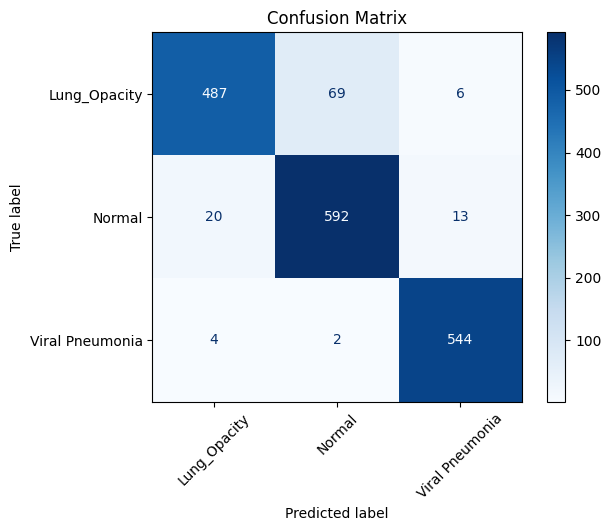

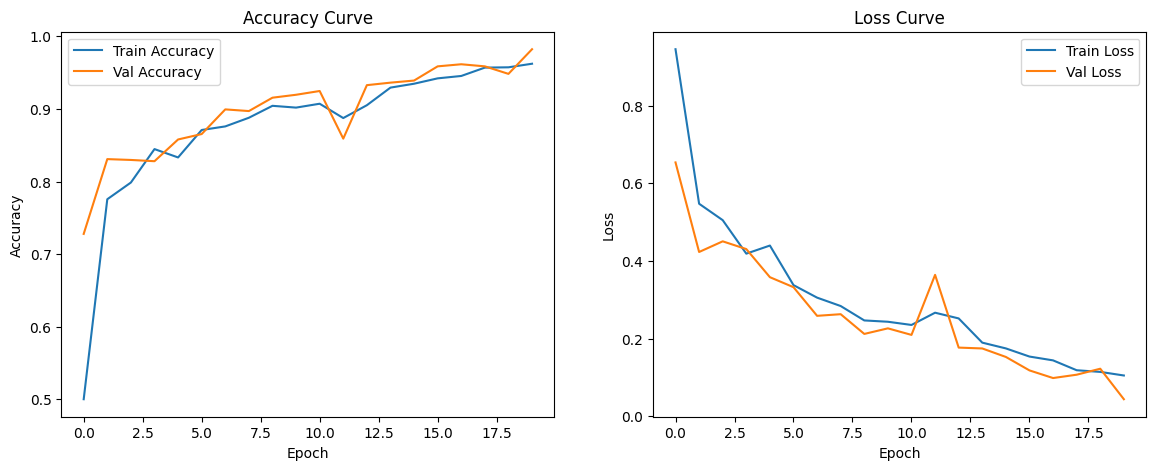

In [5]:
#  EVALUATE 
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")

# METRICS: CONFUSION MATRIX, PRECISION, RECALL, F1 Score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
Y_true = test_gen.classes
Y_pred_probs = model.predict(test_gen)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Labels (class names)
class_labels = list(test_gen.class_indices.keys())

# Classification report
print("\n========== Classification Report ==========")
print(classification_report(Y_true, Y_pred, target_names=class_labels, digits=4))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix")
plt.show()

#  PLOTS 
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **CONFIG BLOCK**

In [6]:
DATA_DIR = "/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image"  
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001
SPLIT_TRAIN = 0.7
SPLIT_VAL = 0.15
SPLIT_TEST = 0.15

# **DATA PREPROCESSING, MODEL BUILDING AND TRAINING (All blocks: first Conv stride=2, MaxPool stride=1)**


In [7]:
# DATA PREPROCESSING 
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=SPLIT_VAL + SPLIT_TEST
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# split validation/test
val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT_TEST / (SPLIT_VAL + SPLIT_TEST))

val_gen = val_test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_gen = val_test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


# BUILD VGG16 FROM SCRATCH (Conv stride=2 for first layer of block, Pool stride=1)
model = Sequential([

    # Block 1
    Conv2D(64, (3,3), activation='relu', padding='same',
           strides=(2,2), input_shape=(*IMG_SIZE, 3)),  
    Conv2D(64, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    MaxPooling2D(pool_size=(2,2), strides=(1,1)),     

    # Block 2
    Conv2D(128, (3,3), activation='relu', padding='same',
           strides=(2,2)),                            
    Conv2D(128, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    MaxPooling2D(pool_size=(2,2), strides=(1,1)),      

    # Block 3
    Conv2D(256, (3,3), activation='relu', padding='same',
           strides=(2,2)),                            
    Conv2D(256, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    Conv2D(256, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    MaxPooling2D(pool_size=(2,2), strides=(1,1)),     

    # Block 4
    Conv2D(512, (3,3), activation='relu', padding='same',
           strides=(2,2)),                             
    Conv2D(512, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    Conv2D(512, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    MaxPooling2D(pool_size=(2,2), strides=(1,1)),    

    # Block 5
    Conv2D(512, (3,3), activation='relu', padding='same',
           strides=(2,2)),                             
    Conv2D(512, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    Conv2D(512, (3,3), activation='relu', padding='same',
           strides=(1,1)),
    MaxPooling2D(pool_size=(2,2), strides=(1,1)),      

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])


# COMPILE 
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# TRAIN 
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg16_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)


Found 2433 images belonging to 3 classes.
Found 1738 images belonging to 3 classes.
Found 1737 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.4354 - loss: 0.9894

77/77 ━━━━━━━━━━━━━━━━━━━━ 38s 329ms/step - accuracy: 0.4369 - loss: 0.9876 - val_accuracy: 0.7601 - val_loss: 0.6592
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7742 - loss: 0.5819

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step - accuracy: 0.7745 - loss: 0.5813 - val_accuracy: 0.8487 - val_loss: 0.3898
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8153 - loss: 0.4627

77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.8155 - loss: 0.4624 - val_accuracy: 0.8504 - val_loss: 0.3691
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8583 - loss: 0.3781

77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 217ms/step - accuracy: 0.8582 - loss: 0.3782 - val_accuracy: 0.8694 - val_loss: 0.3499
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8634 - loss: 0.3449

77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - accuracy: 0.8634 - loss: 0.3450 - val_accuracy: 0.8717 - val_loss: 0.3242
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 0.8666 - loss: 0.3344 - val_accuracy: 0.8182 - val_loss: 0.4324
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8305 - loss: 0.4068

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 0.8307 - loss: 0.4064 - val_accuracy: 0.8936 - val_loss: 0.2707
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8509 - loss: 0.3709

77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - accuracy: 0.8509 - loss: 0.3709 - val_accuracy: 0.9010 - val_loss: 0.2702
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.9062 - loss: 0.2588 - val_accuracy: 0.8959 - val_loss: 0.2551
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.8852 - loss: 0.2688 - val_accuracy: 0.8452 - val_loss: 0.4012
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8510 - loss: 0.3582

77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - accuracy: 0.8513 - loss: 0.3576 - val_accuracy: 0.9166 - val_loss: 0.2422
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9131 - loss: 0.2361

77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - accuracy: 0.9131 - loss: 0.2361 - val_accuracy: 0.9177 - val_loss: 0.2166
Epoch 13/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9152 - loss: 0.2159

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.9153 - loss: 0.2157 - val_accuracy: 0.9292 - val_loss: 0.1920
Epoch 14/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9196 - loss: 0.2134

77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step - accuracy: 0.9196 - loss: 0.2133 - val_accuracy: 0.9344 - val_loss: 0.1535
Epoch 15/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9401 - loss: 0.1440

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.9401 - loss: 0.1443 - val_accuracy: 0.9586 - val_loss: 0.1240
Epoch 16/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.9395 - loss: 0.1570 - val_accuracy: 0.9292 - val_loss: 0.1814
Epoch 17/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.9332 - loss: 0.1741 - val_accuracy: 0.9448 - val_loss: 0.1408
Epoch 18/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9508 - loss: 0.1283

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.9508 - loss: 0.1283 - val_accuracy: 0.9666 - val_loss: 0.1036
Epoch 19/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9581 - loss: 0.1074

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 0.9580 - loss: 0.1075 - val_accuracy: 0.9689 - val_loss: 0.0825
Epoch 20/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9607 - loss: 0.0948

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.9607 - loss: 0.0950 - val_accuracy: 0.9822 - val_loss: 0.0573


# **EVALUATION AND METRICS**

55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.8886 - loss: 0.3481

 Test Accuracy: 93.55%
 Test Loss: 0.2098
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step

========== Classification Report ==========
                 precision    recall  f1-score   support

   Lung_Opacity     0.9475    0.8665    0.9052       562
         Normal     0.8879    0.9632    0.9240       625
Viral Pneumonia     0.9835    0.9745    0.9790       550

       accuracy                         0.9355      1737
      macro avg     0.9396    0.9348    0.9361      1737
   weighted avg     0.9374    0.9355    0.9353      1737



<Figure size 800x600 with 0 Axes>

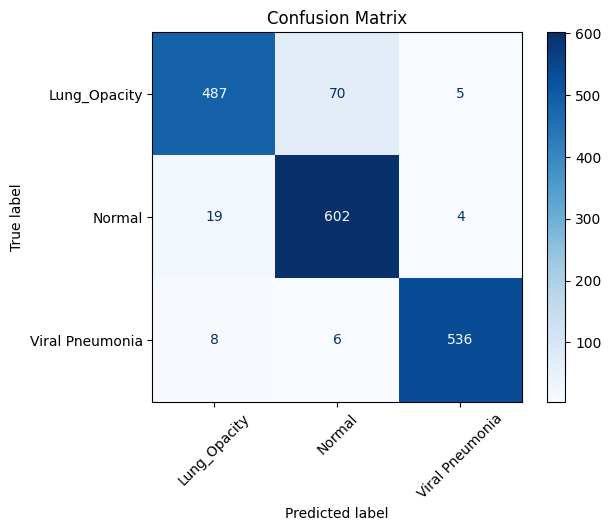

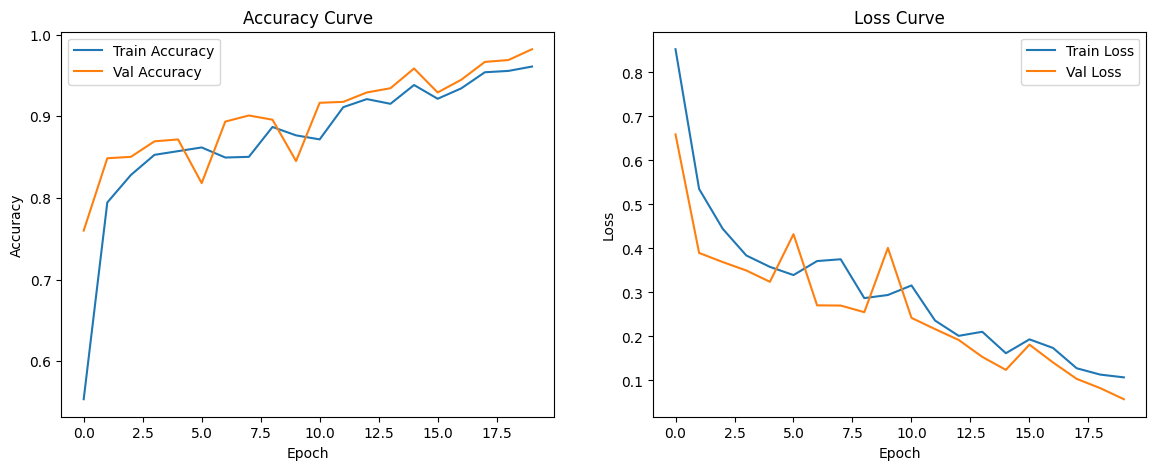

In [8]:
#  EVALUATE 
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")

# METRICS: CONFUSION MATRIX, PRECISION, RECALL, F1 Score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
Y_true = test_gen.classes
Y_pred_probs = model.predict(test_gen)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Labels (class names)
class_labels = list(test_gen.class_indices.keys())

# Classification report
print("\n========== Classification Report ==========")
print(classification_report(Y_true, Y_pred, target_names=class_labels, digits=4))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix")
plt.show()

#  PLOTS 
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()